In [2]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
train.shape[0]

42000

In [5]:
test.shape

(28000, 784)

In [6]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [7]:
train[:, 1:].shape[0]

42000

## Визуализируем исходные данные

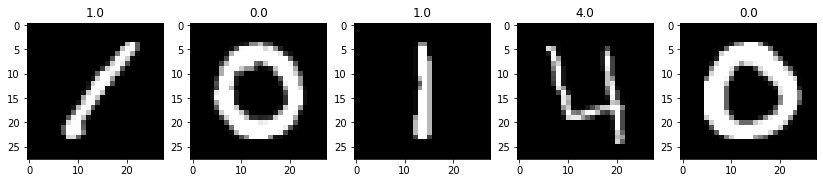

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

### Гистограммы градиентов (HOG)

In [9]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [10]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

#### Вычисляем угол и длину вектора градиента

In [12]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [13]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

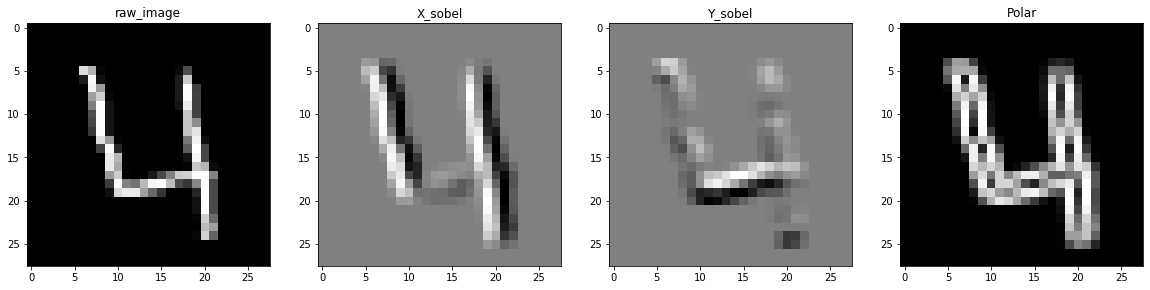

In [14]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1,4,1)
plt.title('raw_image')
plt.imshow(train_img[3,:], cmap='gray')
plt.subplot(1,4,2)
plt.title('X_sobel')
plt.imshow(train_sobel_x[3,:], cmap='gray')
plt.subplot(1,4,3)
plt.title('Y_sobel')
plt.imshow(train_sobel_y[3,:], cmap='gray')
plt.subplot(1,4,4)
plt.title('Polar')
plt.imshow(train_g[3,:], cmap='gray');

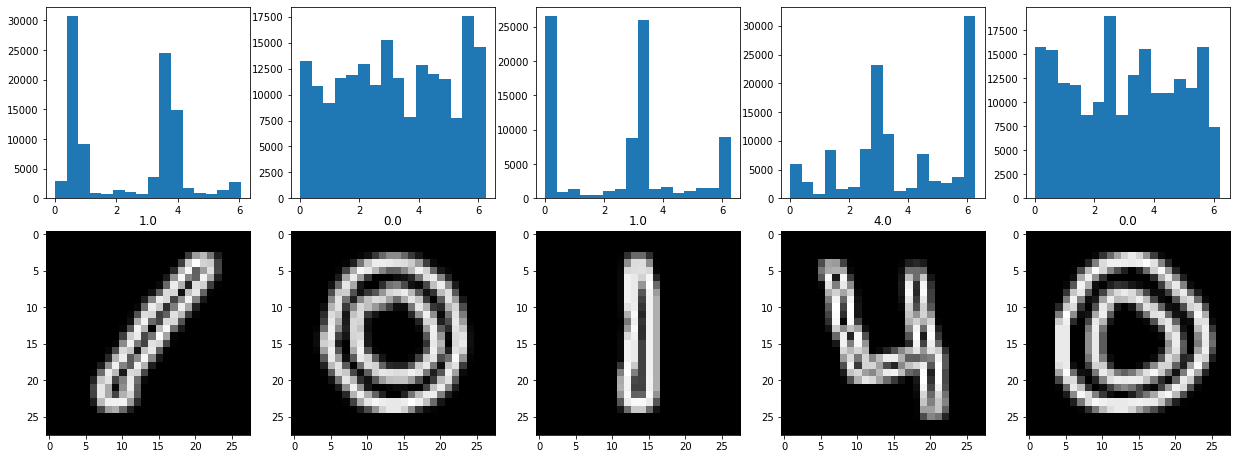

In [15]:
fig = plt.figure(figsize=(30, 12))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

#### Вычисляем гистограммы градиентов

In [16]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [17]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

#### Нормируем вектор гистограммы

In [18]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [19]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

#### Разбиваем выборку на обучение и валидацию

In [20]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

### Строим модели

#### Пробуем чистый KNN

###### чистый KNN дал практически минимальный достаточный уровень точности

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(x_train, y_train)

In [22]:
knn.score(x_val,y_val)

0.5813095238095238

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_val, knn.predict(x_val)))

              precision    recall  f1-score   support

         0.0       0.31      0.46      0.37       816
         1.0       0.95      0.95      0.95       909
         2.0       0.39      0.39      0.39       846
         3.0       0.60      0.65      0.62       937
         4.0       0.66      0.67      0.66       839
         5.0       0.64      0.57      0.60       702
         6.0       0.38      0.35      0.36       785
         7.0       0.84      0.71      0.77       893
         8.0       0.49      0.42      0.45       835
         9.0       0.64      0.58      0.61       838

    accuracy                           0.58      8400
   macro avg       0.59      0.57      0.58      8400
weighted avg       0.60      0.58      0.59      8400



#### Пробуем случайный лес + grid search

###### Случайный лес дал более высокий результат - 0.62

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

depths = np.arange(1,20)
n_estimators = [10,15,25,50,100]
samples_leaves = [15,20,25]

params = {'n_estimators': n_estimators,
          'max_depth': depths,
          'min_samples_leaf': samples_leaves,
         }

rfc_grid = GridSearchCV(RandomForestClassifier(), params, cv=10, n_jobs=-1)
rfc_grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [25]:
rfc_grid.best_params_

{'max_depth': 17, 'min_samples_leaf': 15, 'n_estimators': 100}

In [26]:
rfc_grid.score(x_val, y_val)

0.6292857142857143

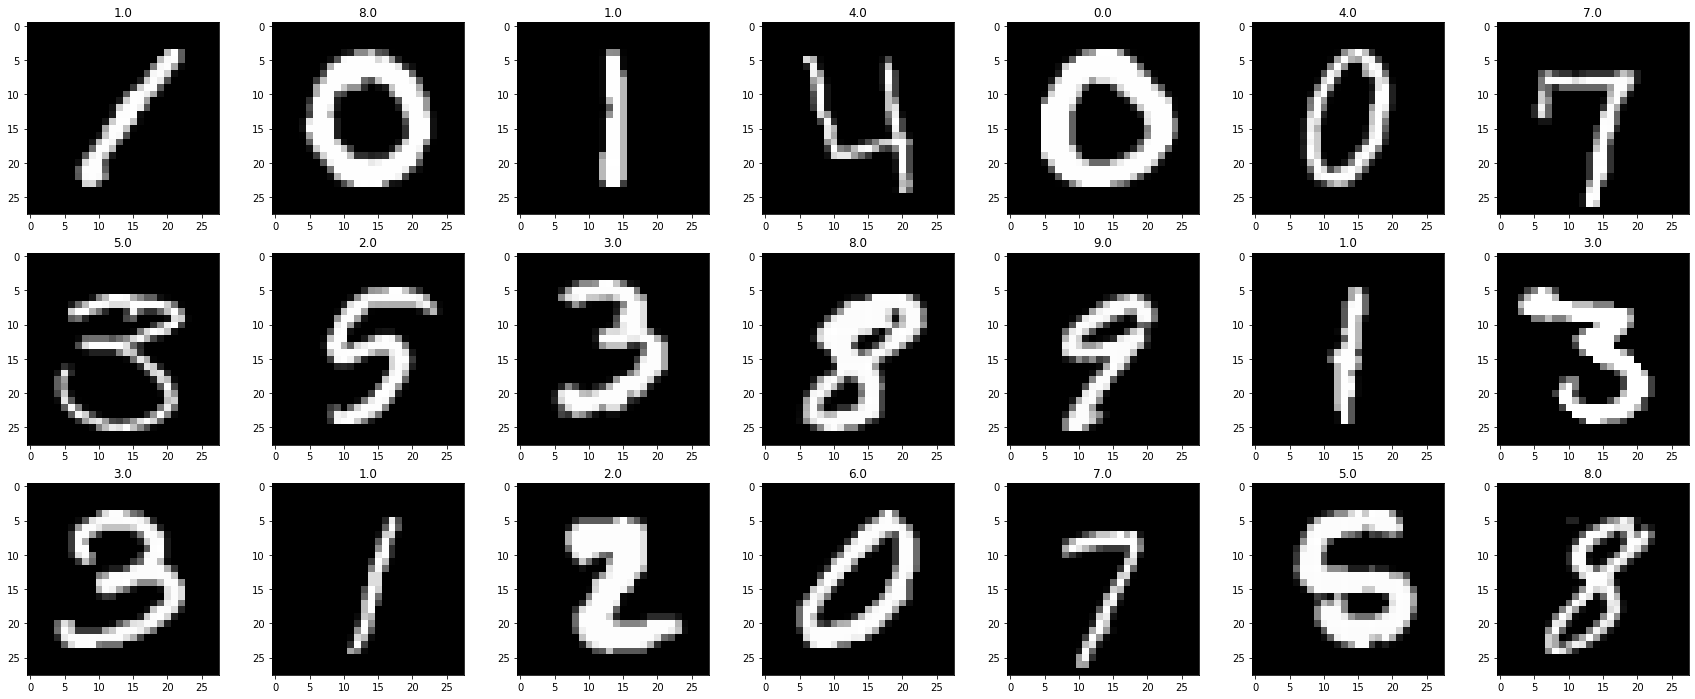

In [27]:
fig = plt.figure(figsize=(30, 12))
for i, img in enumerate(train_img[0:21], 1):
    subplot = fig.add_subplot(3, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % rfc_grid.predict(train_hist)[i - 1]);

### Понижение размерности (PCA)

In [28]:
train_pca = train_img.reshape(-1, 28 * 28).astype(np.float32)
test_pca = test_img.reshape(-1, 28 * 28).astype(np.float32)

In [29]:
# центрируем данные
train_pca_mean = train_pca.mean(axis=0)
train_pca -= train_pca_mean

# центрируем данные для финальной валидации
test_pca_mean = test_pca.mean(axis=0)
test_pca -= test_pca_mean

In [30]:
# матрица ковариации признаков
cov = np.dot(train_pca.T, train_pca) / train_pca.shape[0]
cov_test = np.dot(test_pca.T, test_pca) / test_pca.shape[0]

In [31]:
U, S, _ = np.linalg.svd(cov)
U_t, S_t, _t = np.linalg.svd(cov_test)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

#### Собственные числа

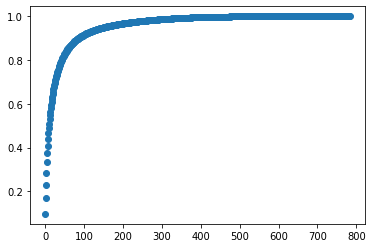

In [32]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')
plt.show()

In [33]:
for i in range(5):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[000] 0.097
[001] 0.169
[002] 0.231
[003] 0.284
[004] 0.333


#### Понижаем размерность

In [35]:
S_thr = 0.9  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=86 S=0.901


In [37]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(train_pca, U_t[:, :n_comp])
X_test_rot_reduced = np.dot(test_pca, U_t[:, :n_comp])

#### Разбиваем на обучайющую и тестовую выбрки

In [43]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, Xrot_reduced, test_size=0.2,
    random_state=42)

### Строим модель

#### Пробуем чистый KNN

###### чистый KNN на PCA дал наиболее высокий уровень точности

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [45]:
knn.score(x_val,y_val)

0.9707142857142858

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_val, knn.predict(x_val)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       816
         1.0       0.96      1.00      0.98       909
         2.0       0.98      0.96      0.97       846
         3.0       0.97      0.96      0.97       937
         4.0       0.99      0.96      0.98       839
         5.0       0.96      0.97      0.96       702
         6.0       0.97      0.99      0.98       785
         7.0       0.96      0.97      0.96       893
         8.0       0.99      0.95      0.97       835
         9.0       0.95      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [66]:
result = knn.predict(X_test_rot_reduced)
result

array([2., 0., 9., ..., 3., 9., 2.])

In [75]:
n_neighbors = np.arange(3,10)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
p = [1,2]

params = {'n_neighbors': n_neighbors,
          'weights': weights,
          'algorithm': algorithm,
          'p': p
         }

knn_grid = GridSearchCV(KNeighborsClassifier(), params, cv=10, n_jobs=-1)
knn_grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([3, 4, 5, 6, 7, 8, 9]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [76]:
knn_grid.score(x_val,y_val)

0.9741666666666666

In [77]:
result2 = knn_grid.predict(X_test_rot_reduced)
result2

array([2., 0., 9., ..., 3., 9., 2.])

## Готовим файл для отправки

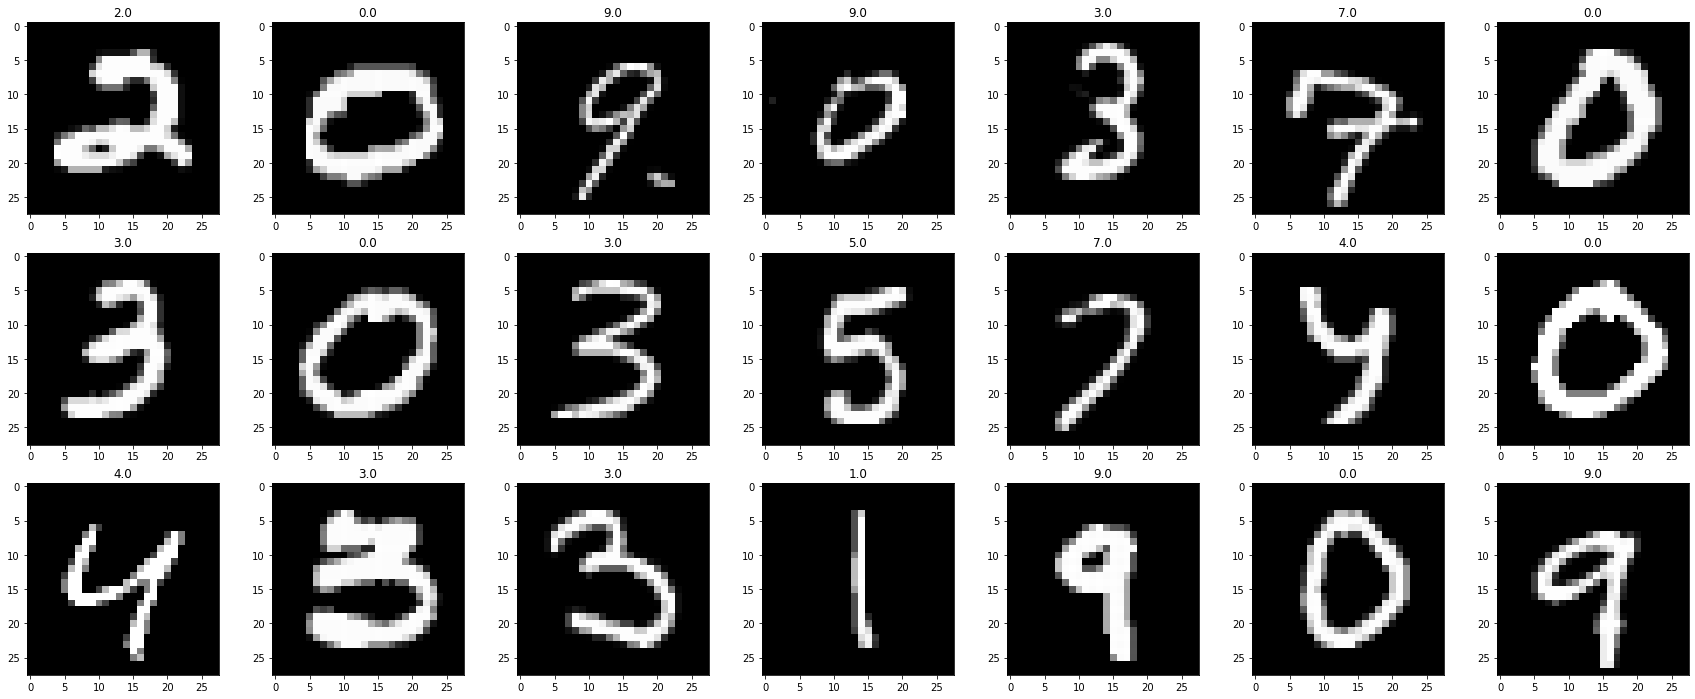

In [67]:
fig = plt.figure(figsize=(30, 12))
for i, img in enumerate(test_img[0:21], 1):
    subplot = fig.add_subplot(3, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % result[i - 1]);

In [81]:
submit2 = pd.concat([pd.Series(range(1,28001), name='ImageId'), 
                    pd.Series(result2, name='Label', dtype=int)], axis=1)
submit2.to_csv('submit2.csv', index=False)                  

In [82]:
!head submit2.csv

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0
